https://www.datacamp.com/community/tutorials/networkx-python-graph-tutorial

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from random import shuffle

In [77]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.spatial import Voronoi, voronoi_plot_2d

In [101]:
from sklearn.neighbors import NearestNeighbors

In [110]:
cols = ['X', 'Y', 'ID', 'NOMBRE', 'NIVEL']
schools = (pd.read_csv('./data/schools.csv', sep=';', usecols=cols)
             .rename(columns={'X': 'x', 'Y': 'y', 'ID': 'tag', 'NOMBRE': 'name', 'NIVEL': 'level'}))

In [111]:
schools = (schools.loc[schools.level.isin(['PRIMARIA', 'PRIMARIO'])]
                  .drop(columns=['level'])
                  .reset_index(drop=True)
)

In [49]:
cols = ['long', 'lat', 'id', 'nom_polid']
pools = (pd.read_csv('./data/pools.csv', usecols=cols)
           .rename(columns={'long': 'x', 'lat': 'y', 'id': 'tag', 'nom_polid': 'name'}))

In [51]:
g = nx.Graph()

In [52]:
for i, node in schools.iterrows():
    g.add_node(node['tag'], x=node['x'], y=node['y'], tipo='school')
    
for i, node in pools.iterrows():
    g.add_node(node['tag'], x=node['x'], y=node['y'], tipo='pool')

In [54]:
def color(tipo):
    return 'black' if tipo=='school' else 'red'

In [60]:
node_pos = {node[0]: (node[1]['x'], node[1]['y']) for node in g.nodes(data=True)}

In [56]:
node_col = [color(node[1]['tipo']) for node in g.nodes(data=True)]

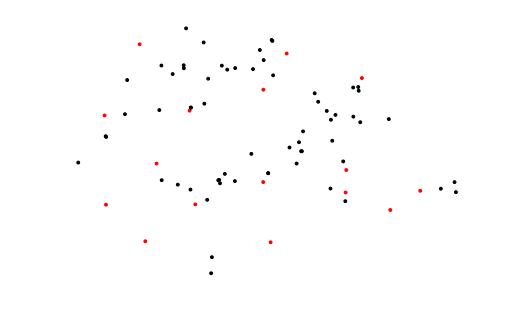

In [62]:
nx.draw(g, pos=node_pos, node_size=8, node_color=node_col)

In [79]:
pools_vor = np.array([[row['x'], row['y']] for i, row in pools.iterrows()])
schools_vor = np.array([[row['x'], row['y']] for i, row in schools.iterrows()])

In [71]:
vor = Voronoi(pools_vor)

In [152]:

colors_list = list(colors._colors_full_map.values())

In [159]:
shuffle(colors_list)

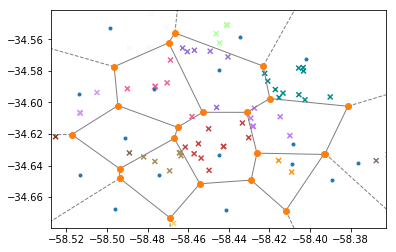

In [178]:
voronoi_plot_2d(vor, line_colors='grey')
plt.scatter(schools_vor[:,0], schools_vor[:,1],
            s=25, c=[colors_list[i] for i in schools.closest], marker='x')
plt.show()

In [105]:
knn = NearestNeighbors(n_neighbors=1).fit(pools.loc[:, ['x', 'y']].values)

In [119]:
indeces = knn.kneighbors(schools.loc[:, ['x', 'y']].values, return_distance=False)

In [136]:
schools = schools.assign(closest = pools.loc[indeces.flatten(), 'tag'].values)

In [137]:
schools

,x,y,tag,name,closest
0,-58.405519,-34.595092,77,CCI - SCUOLA EDMONDO DE AMICIS - NIVEL PRIMARIO,13
1,-58.457081,-34.632530,184,COLEGIO NTRA. SRA. DE LA MISERICORDIA (A 58 FL...,2
2,-58.405589,-34.578193,211,COLEGIO BAYARD A - 435,13
3,-58.390090,-34.596528,79,COLEGIO MARISTA CHAMPAGNAT - NIVEL PRIMARIO,13
4,-58.489044,-34.565421,38,COLEGIO NUEVOS AIRES - NIVEL PRIMARIO,15
5,-58.449178,-34.567504,185,COLEGIO NTRA. SRA. DE LA MISERICORDIA (A - 57 ...,3
6,-58.462756,-34.565493,209,BELGRANO DAY SCHOOL - A 38,3
7,-58.503933,-34.573851,62,DAMASA ZELAYA DE SAAVEDRA - NIVEL PRIMARIO,15
8,-58.513077,-34.606870,68,EEEFL N° 3 D.E. 17,8
9,-58.449707,-34.643032,12,EPC 22 D.E. 11,2
